In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb


color_pal = sns.color_palette()

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/sainihimanshu1999/Machine_Learning/main/Time%20Series%20-%20XgBoost/PJME_hourly.csv')

In [19]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [20]:
df = df.set_index('Datetime')

In [21]:
df.index  = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME energy consumption in megawatts'}, xlabel='Datetime'>

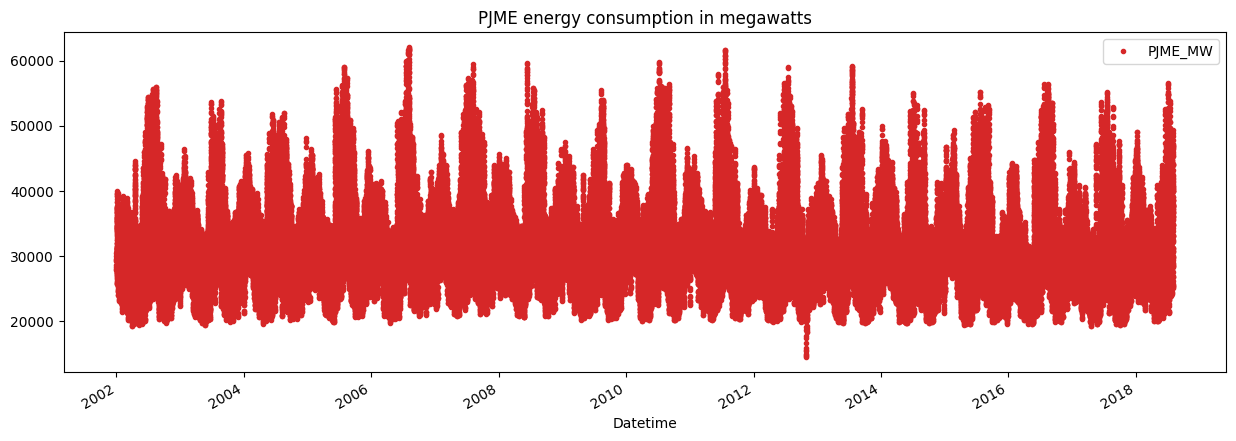

In [22]:
df.plot(style='.', figsize=(15,5), color = color_pal[3], title= 'PJME energy consumption in megawatts')

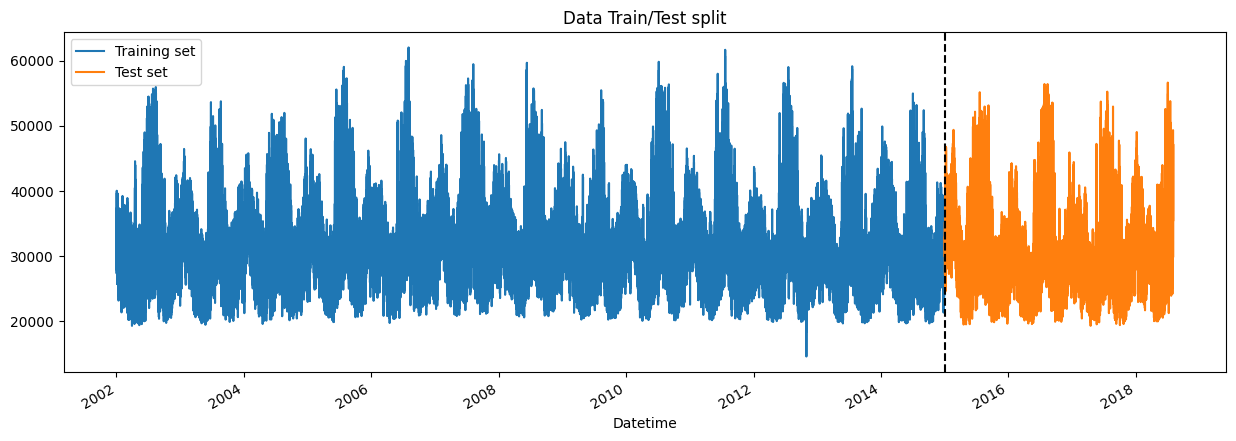

In [24]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax , label = 'Training Set' , title='Data Train/Test split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training set', 'Test set'])
plt.show()

<Axes: title={'center': 'one week data'}, xlabel='Datetime'>

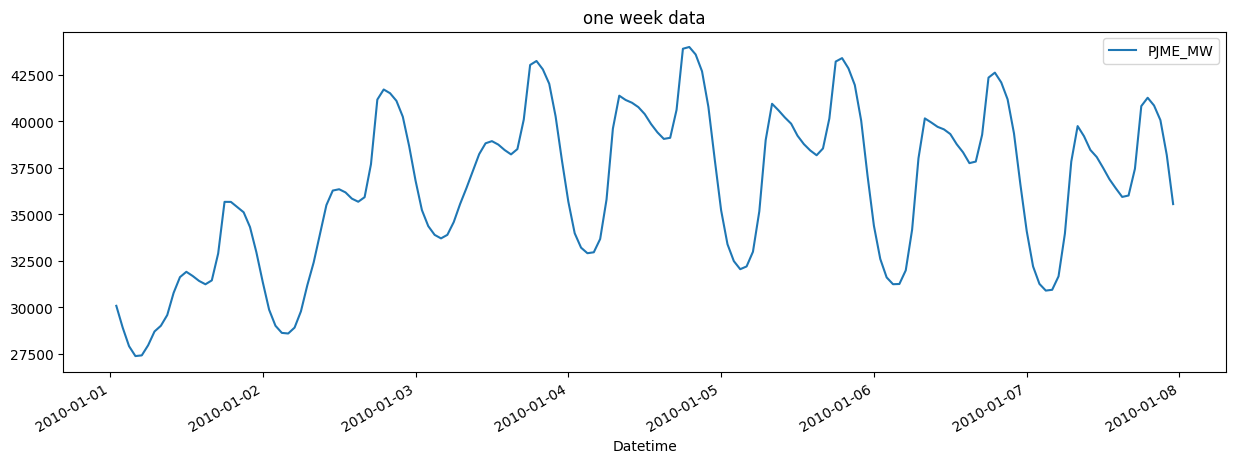

In [27]:
df.loc[(df.index > '01-01-2010') & (df.index <'01-08-2010')].plot(figsize=(15,5), title ='one week data')

In [36]:

def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df




In [31]:
df = create_features(df)
df.head(100)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2002-12-29 00:00:00,28976.0,0,6,4,12,2002,363
2002-12-27 01:00:00,28445.0,1,4,4,12,2002,361
2002-12-27 02:00:00,27266.0,2,4,4,12,2002,361


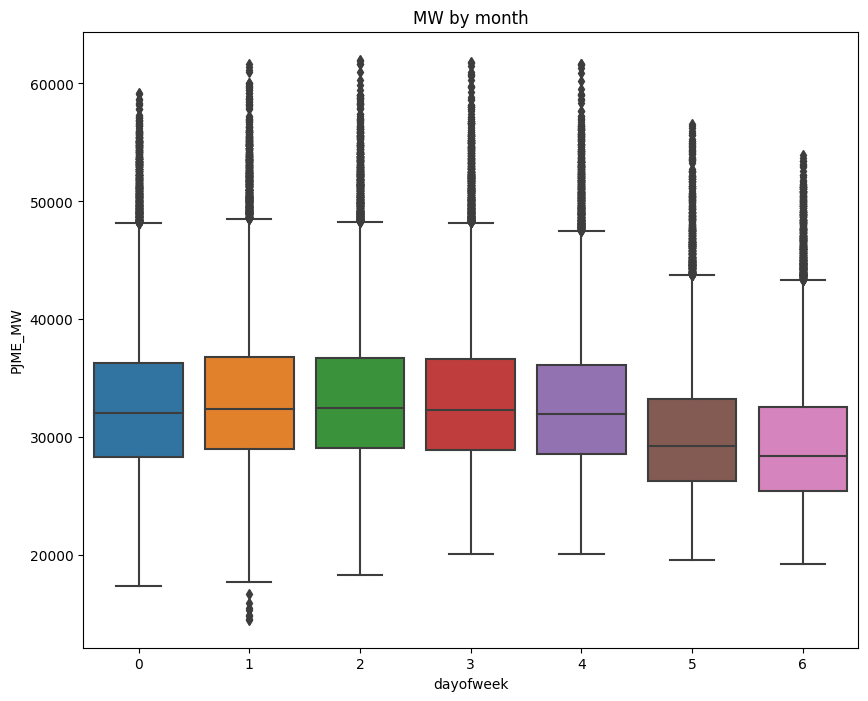

In [34]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='dayofweek', y = 'PJME_MW')
ax.set_title('MW by month')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error

In [37]:
train = create_features(train)
test = create_features(test)

In [39]:
features = [ 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']

target = 'PJME_MW'

In [40]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [47]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50,eta=0.01)
reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
fi  = pd.DataFrame(data=reg.feature_importances_,
                   index = reg.feature_names_in_,
                   columns = ['importance'])

<Axes: title={'center': 'Feature Importance'}>

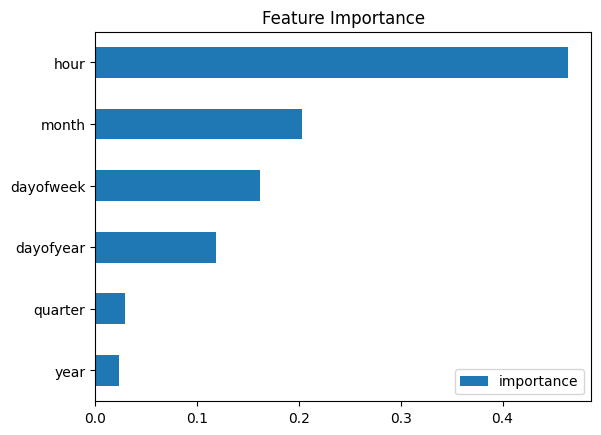

In [52]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [54]:
test['predictions'] = reg.predict(X_test)

In [55]:
df = df.merge(test[['predictions']], how='left', left_index = True, right_index=True)

Text(0.5, 1.0, 'Raw data and predicitons')

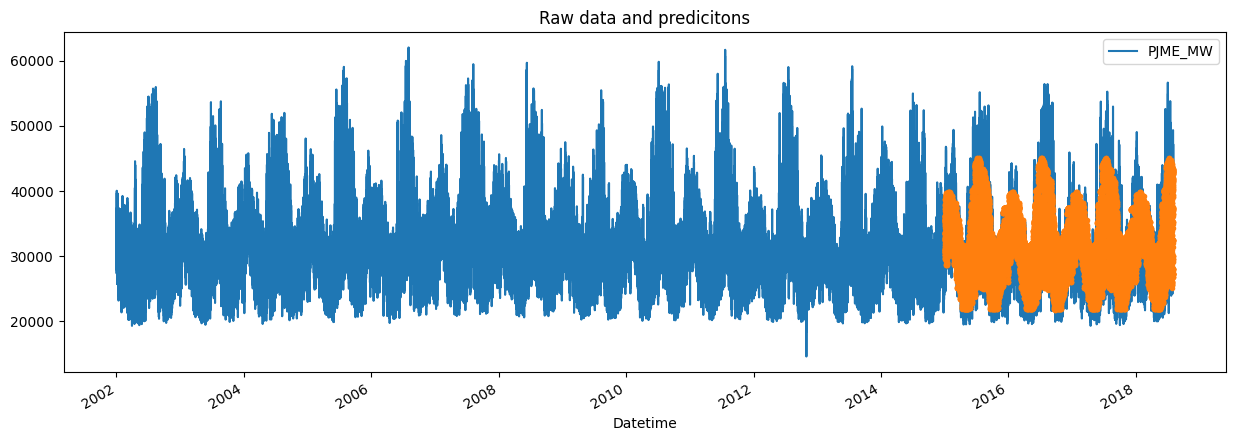

In [58]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax,style = '.')
ax.set_title('Raw data and predicitons')

In [66]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE score on Test set: {score:0.2f}')

RMSE score on Test set: 3741.03


In [68]:
test['error'] = np.abs(test[target] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64